<a href="https://www.kaggle.com/code/samithsachidanandan/fruit-and-vegetable-classif-transfer-learning?scriptVersionId=274773665" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Input

train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
  

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

   
    df = pd.concat([filepath, labels], axis=1)

 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

2025-11-09 11:31:24.059124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762687884.478269      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762687884.595142      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['corn' 'mango' 'spinach' 'carrot' 'tomato' 'lettuce' 'sweetcorn' 'banana'
 'eggplant' 'onion' 'sweetpotato' 'garlic' 'peas' 'turnip' 'potato'
 'raddish' 'soy beans' 'ginger' 'jalepeno' 'pear' 'cucumber' 'grapes'
 'apple' 'kiwi' 'bell pepper' 'beetroot' 'watermelon' 'paprika' 'lemon'
 'pineapple' 'capsicum' 'chilli pepper' 'pomegranate' 'cauliflower'
 'orange' 'cabbage']


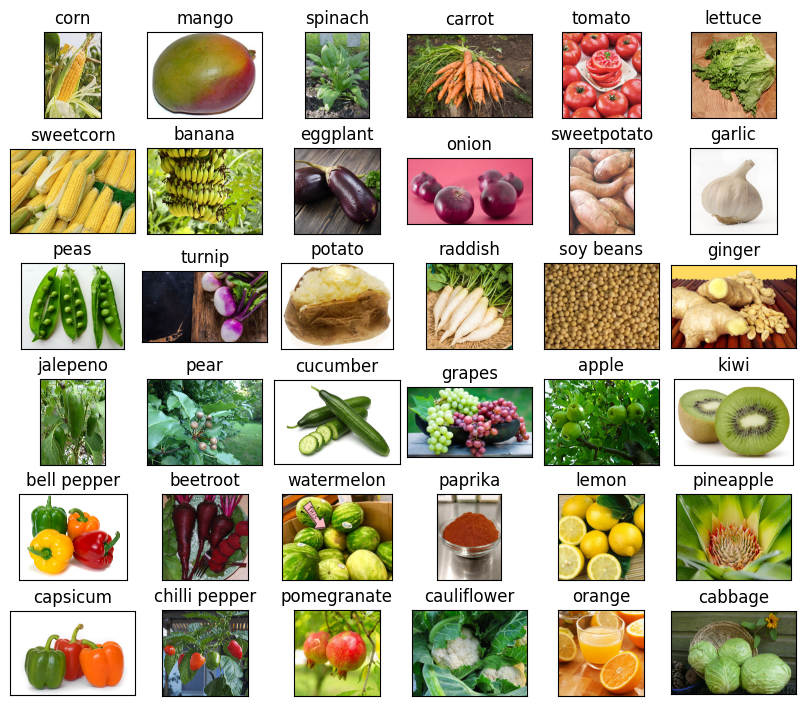

In [3]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()


fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [4]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    image_size=(224, 224),
    shuffle=True
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    image_size=(224, 224),
    shuffle=False
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    image_size=(224, 224),
    shuffle=False
)

Found 3115 files belonging to 36 classes.


I0000 00:00:1762687922.308052      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762687922.308756      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [5]:
input_shape = (224, 224, 3)
class_names = train_ds_raw.class_names
num_classes = len(class_names)

In [6]:
batch = next(train_ds_raw.as_numpy_iterator())

In [7]:
batch[0].shape

(32, 224, 224, 3)

In [8]:
class_names = train_ds_raw.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [9]:
idx_to_class = {i: name for i, name in enumerate(class_names)}
print("Index → Class:", idx_to_class)


Index → Class: {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


In [10]:
class_to_idx = {name: i for i, name in enumerate(class_names)}
print("Class → Index:", class_to_idx)

Class → Index: {'apple': 0, 'banana': 1, 'beetroot': 2, 'bell pepper': 3, 'cabbage': 4, 'capsicum': 5, 'carrot': 6, 'cauliflower': 7, 'chilli pepper': 8, 'corn': 9, 'cucumber': 10, 'eggplant': 11, 'garlic': 12, 'ginger': 13, 'grapes': 14, 'jalepeno': 15, 'kiwi': 16, 'lemon': 17, 'lettuce': 18, 'mango': 19, 'onion': 20, 'orange': 21, 'paprika': 22, 'pear': 23, 'peas': 24, 'pineapple': 25, 'pomegranate': 26, 'potato': 27, 'raddish': 28, 'soy beans': 29, 'spinach': 30, 'sweetcorn': 31, 'sweetpotato': 32, 'tomato': 33, 'turnip': 34, 'watermelon': 35}


In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [12]:
def prepare_dataset(ds, augment=False):
    preprocessing = tf.keras.Sequential([
        tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)
    ])
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.map(lambda x, y: (preprocessing(x), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds_raw, augment=True)
val_ds = prepare_dataset(val_ds_raw, augment=False)
test_ds = prepare_dataset(test_ds_raw, augment=False)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


In [14]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
base_model.trainable = True
fine_tune_at = 100  

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [16]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss='sparse_categorical_crossentropy',   
    metrics=['accuracy']
)

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,  
    restore_best_weights=True,
    verbose=1
)

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [21]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,172 (9.90 MB)

 Trainable params: 2,198,628 (8.39 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [22]:
hist = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr, tensorboard_callback],
    verbose=1
)


Epoch 1/30


I0000 00:00:1762687946.609247      70 service.cc:148] XLA service 0x7b240c005410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762687946.610920      70 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762687946.610951      70 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762687949.754380      70 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762687960.940804      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 87s 559ms/step - accuracy: 0.1163 - loss: 3.5184 - val_accuracy: 0.6325 - val_loss: 1.4288 - learning_rate: 1.0000e-04
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6045 - loss: 1.4984 - val_accuracy: 0.7265 - val_loss: 0.8558 - learning_rate: 1.0000e-04
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7820 - loss: 0.8018 - val_accuracy: 0.7607 - val_loss: 0.7003 - learning_rate: 1.0000e-04
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8610 - loss: 0.5106 - val_accuracy: 0.7863 - val_loss: 0.5976 - learning_rate: 1.0000e-04
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9097 - loss: 0.3359 - val_accuracy: 0.8034 - val_loss: 0.5439 - learning_rate: 1.0000e-04
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9588 - loss: 0.1992 - val_accuracy: 0.8234 - val_loss: 0.4709 - learning_rate: 1.0000e-04
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9736 - loss: 0

In [23]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 612ms/step - accuracy: 0.8957 - loss: 0.3381

Test Accuracy: 0.9164
Test Loss: 0.2539


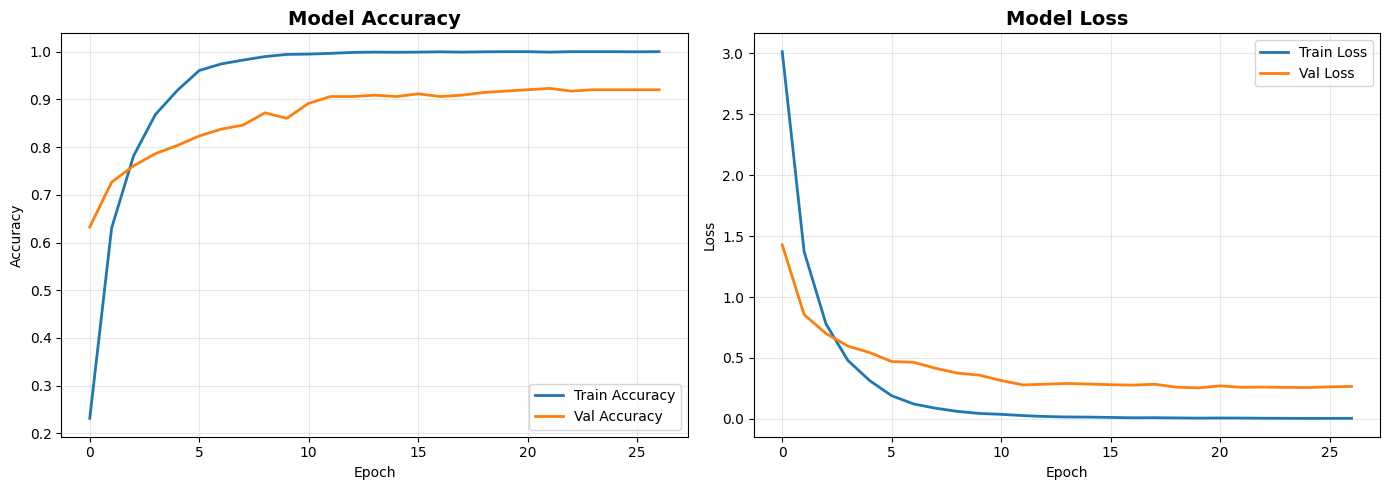

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].plot(hist.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(hist.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(hist.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(hist.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()



In [25]:
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

In [26]:
model.save('model.keras')